### Define topology

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from codes.utils import printoptions
from codes.graph_utils import Graph, spectral_gap


class TunableChain(Graph):

    def __init__(self, a, b, mixing, delta_max, p):
        self.a = a
        self.b = b
        self.delta_max = delta_max
        self.p = p

        if delta_max > 1-a-b:
            raise NotImplementedError
        
        metropolis = np.zeros((6, 6))
        metropolis[2:, 2:] = mixing
        metropolis[0, 0] = 1 - delta_max
        metropolis[0, 3] = delta_max
        metropolis[3, 0] = delta_max
        metropolis[3, 3] -= delta_max

        metropolis[1, 1] = 1 - delta_max
        metropolis[1, 4] = delta_max
        metropolis[4, 1] = delta_max
        metropolis[4, 4] -= delta_max

        self.metropolis_weight = metropolis

    
    def get_neighbors_index(self, good_node, include_self):
        if good_node == 2:
            return [2, 3] if include_self else [3] 
        
        if good_node == 3:
            return [0, 2, 3, 4] if include_self else [0, 2, 4]

        if good_node == 4:
            return [1, 3, 4, 5] if include_self else [1, 3, 5]
        
        if good_node == 5:
            return [4, 5] if include_self else [4]
        
        raise NotImplementedError

    def get_neighbors_weight(self, good_node, include_self):
        indices = self.get_neighbors_index(good_node, include_self)
        weights = [self.metropolis_weight[good_node][j] for j in indices]
        return weights

    def get_good_neighbors_index(self, good_node, include_self):
        indices = self.get_neighbors_index(good_node, include_self)
        return [i for i in indices if i not in [0, 1]]

    def delta_i(self, good_node):
        return self.metropolis_weight[good_node, 0] + self.metropolis_weight[good_node, 1]


class DataManager(object):
    
    def __init__(self, data, graph, attacker):
        assert len(data) == 4

        self.good_data = data
        self.graph = graph
        self.attacker = attacker
        attacker.configure(self, graph)
    
    def getDataOn(self, good_node):
        data = [self.attacker(0), self.attacker(1)] + self.good_data
        indices = self.graph.get_neighbors_index(good_node, include_self=True)
        return [data[i] for i in indices]

    def setGoodData(self, data):
        self.good_data = data

    def get(self, good_node):
        return self.good_data[good_node - 2]

class Attack(object):

    def configure(self, data_manager, graph):
        self.data_manager = data_manager
        self.graph = graph

    def __call__(self, byzantine_node):
        pass


class ConstValueAttack(Attack):
    def __init__(self, v0, v1):
        self.v0 = v0
        self.v1 = v1

    def __call__(self, byzantine_node):
        if byzantine_node == 0:
            return self.v0
        if byzantine_node == 1:
            return self.v1
        raise NotImplementedError

class DissensusAttack(Attack):

    def __init__(self, eps):
        self.eps = eps

    def __call__(self, byzantine_node):
        data = self.data_manager.good_data        
        m = self.graph.metropolis_weight[4 if byzantine_node else 3]
        if byzantine_node == 0:
            v = m[2] * (data[0] - data[1]) + m[4] * (data[2] - data[1])
            v /= m[0]
            return data[1] - self.eps * v

        if byzantine_node == 1:
            v = m[3] * (data[1] - data[2]) + m[5] * (data[3] - data[2])
            v /= m[1]
            return data[2] - self.eps * v 

        raise NotImplementedError


In [2]:
class Experiment(object):

    def __init__(self, data_manager, graph, n, b, p, delta_max, T):
        # Number of workers
        self.n = n
        # Number of Byzantine workers
        self.b = b
        self.p = p
        self.delta_max = delta_max
        self.T = T

        self.data_manager = data_manager
        self.graph = graph
        self.mu0 = sum(data_manager.good_data) / len(data_manager.good_data)

        self.consensus_distances = []
        self.errors = []

    def consensus_distance(self):
        data = self.data_manager.good_data
        mu = sum(data) / len(data)
        return sum((i - mu) ** 2 for i in data) / len(data)

    def error(self):
        data = self.data_manager.good_data
        return sum((i - self.mu0) ** 2 for i in data) / len(data)

    def run(self):
        self.consensus_distances.append(self.consensus_distance())
        self.errors.append(self.error())
        for t in range(self.T):
            new_data = []
            for i in range(self.b, self.n):
                # Aggregation on good worker i
                new_data.append(self.agg(i))

            self.data_manager.setGoodData(new_data)
            self.consensus_distances.append(self.consensus_distance())
            self.errors.append(self.error())

    def agg(self, i):
        raise NotImplementedError



# SSClip
def clip(v, tau):
    v_norm = abs(v)
    scale = min(1, tau / v_norm)
    return v * scale

class SSClip(Experiment):

    def agg(self, i):
        v = self.data_manager.get(i)

        delta_i = self.graph.delta_i(i)
        good_local_indices = self.graph.get_good_neighbors_index(i, include_self=False)

        tau = 0
        for j in good_local_indices:
            w = self.graph.metropolis_weight[i][j]
            d = self.data_manager.get(j)
            distance = (d - v) ** 2
            tau += w * distance
        
        if delta_i == 0:
            tau = np.inf
        else:
            tau /= delta_i
            tau = np.sqrt(tau)

        local_data = self.data_manager.getDataOn(i)
        weights = self.graph.get_neighbors_weight(i, include_self=True)
        new_data = 0
        a = []
        for index, vv, w in zip(self.graph.get_neighbors_index(i, include_self=True), local_data, weights):
            if vv == v:
                z = v
            else:
                z = v + clip(vv - v, tau)
            new_data += w * z
            a.append(f"Clip node {index} from {vv} to {z}")
        
        return new_data

class MedianWeighted(Experiment):

    def agg(self, i):
        _data = self.data_manager.getDataOn(i)
        mixing_weights = self.graph.get_neighbors_weight(i, include_self=True)
        N = 100
        data = []
        for d, w in zip(_data, mixing_weights):
            count = int(N * w)
            data += [d] * count

        sorted_data = sorted(data)
        mid_index = len(data) // 2
        if len(data) % 2:
            median = sorted_data[mid_index]
        else:
            median = (sorted_data[mid_index] + sorted_data[mid_index-1]) / 2
        return median

class TrimmedMeanWeighted(Experiment):

    def _get_n_byzantine_neighbor(self, i):
        # This function use strong knowledge
        if i == 2 or i == 5:
            return 0
        if i == 3 or i == 4:
            return 1
        raise NotImplementedError
        
    def agg(self, i):
        _data = self.data_manager.getDataOn(i)
        mixing_weights = self.graph.get_neighbors_weight(i, include_self=True)
        N = 100
        data = []
        for d, w in zip(_data, mixing_weights):
            count = int(N * w)
            data += [d] * count

        b = int(N * self.graph.delta_i(i))
        b = 49 if b >= 50 else b

        sorted_data = sorted(data)
        sorted_data = sorted_data[b:len(sorted_data) - b]
        return sum(sorted_data) / len(sorted_data)

class Median(Experiment):

    def agg(self, i):
        data = self.data_manager.getDataOn(i)
        sorted_data = sorted(data)
        mid_index = len(data) // 2
        if len(data) % 2:
            median = sorted_data[mid_index]
        else:
            median = (sorted_data[mid_index] + sorted_data[mid_index-1]) / 2
        return median

class TrimmedMean(Experiment):

    def _get_n_byzantine_neighbor(self, i):
        # This function use strong knowledge
        if i == 2 or i == 5:
            return 0
        if i == 3 or i == 4:
            return 1
        raise NotImplementedError
        
    def agg(self, i):
        b = self._get_n_byzantine_neighbor(i)
        data = self.data_manager.getDataOn(i)

        sorted_data = sorted(data)
        sorted_data = sorted_data[b:len(sorted_data) - b]
        return sum(sorted_data) / len(sorted_data)



Note that combining median/trimmed mean with mixing matrix is tricky because:

- If we ignore the mixing matrix, then they are robust to the dissensus attack.
- If we consider the mixing matrix, that is, duplicate values according to the mixing weight, then they are no longer cursed by heterogeneity. (This is however not the implementation of Bridge.)

In [25]:
N = 6
b = 2
data0 = [0, 0, 200, 200]

a = 1 / 3
results = []
for attacker, attack_name in [(ConstValueAttack(0, 200), "constant"), (DissensusAttack(1), "dissensus")]:
    for Defense, defense_name in [(SSClip, "SSClip"), (Median, "Median"), (TrimmedMean, "TM"),
    (MedianWeighted, "Median*"), (TrimmedMeanWeighted, "TM*")]:
        for delta_max in [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]:
            for beta in [0.58, 0.45, 0.35, 0.267, 0.19, 0.12, 0.08, 0.04, 0.02, 0.01, 1e-3]:
                mixing = np.array([
                    [1-a, a, 0, 0],
                    [a, 1-a-beta, beta, 0],
                    [0, beta, 1-a-beta,a],
                    [0, 0, a, 1-a]
                ])
                p = spectral_gap(mixing) ** 2
                try:
                    graph = TunableChain(a, beta, mixing, delta_max=delta_max, p=p)
                    data_manager = DataManager(data0, graph, attacker)
                    runner = Defense(data_manager, graph, N, b, p, delta_max, 100)
                    runner.run()
                    results.append({"exp": runner, "attack": attack_name, "defense": defense_name, 'beta': beta})
                except:
                    pass


### Performance of aggregators under constant value attack

Note that this part of result is not included in the paper.

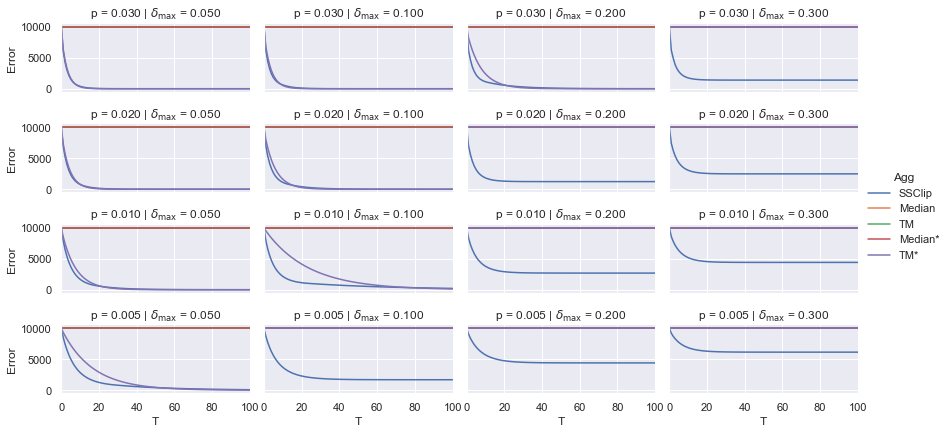

In [281]:
import pandas as pd
import seaborn as sns
stats = []
for res in results:
    delta_max, p = res['exp'].delta_max, res['exp'].p
    if delta_max > 0.3 or res['beta'] > 0.268 or res['beta'] < 0.08:
        continue
    if res['attack'] == "dissensus":
        continue

    for t, e, cd in zip(range(res['exp'].T+1), res['exp'].errors, res['exp'].consensus_distances):
        if t > 100:
            break
        stats.append({r"$\delta_{\max}$ value": delta_max, "p_value": p, "Error": e, r"$\Xi$": cd, "T": t, "Agg": res['defense']})


plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 11
sns.set(rc={'figure.figsize': (6.75, 3)})

df = pd.DataFrame(stats)
df['p'] = df['p_value'].apply(lambda x: "{:.3f}".format(x))
df[r"$\delta_{\max}$"] = df[r"$\delta_{\max}$ value"].apply(lambda x: "{:.3f}".format(x))
g = sns.relplot(data=df, x="T", y="Error", col=r"$\delta_{\max}$", row="p", kind='line', hue="Agg", height=1.5, aspect=2)

g.set(xlim=(0, 100))
# g.savefig("./consensus_constant_attack.pdf", bbox_inches="tight", dpi=720)

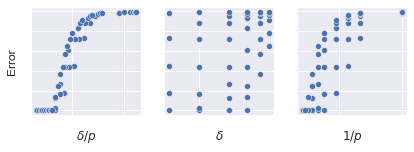

In [282]:
import pandas as pd
import seaborn as sns

stats = []
for res in results:
    delta_max, p = res['exp'].delta_max, res['exp'].p
    if res['defense'] != 'SSClip':
        continue
    if res['attack'] == "dissensus":
        continue
    for t, e, cd in zip(range(res['exp'].T+1), res['exp'].errors, res['exp'].consensus_distances):
        if t > 100:
            break
        stats.append({r"$\delta_{\max}$ value": delta_max, "p_value": p, "Error": e, r"$\Xi$": cd, "T": t, "Agg": res['defense']})


df = pd.DataFrame(stats)
df = df[df['T'] == 100]
df[r'$\delta$'] = df[r"$\delta_{\max}$ value"]
df[r'$1/p$'] = 1 / df["p_value"]
df[r'$\delta/p$'] = df[r"$\delta_{\max}$ value"] / df['p_value'] ** 1
df[r'$\delta/p^2$'] = df[r"$\delta_{\max}$ value"] / df['p_value'] ** 2

# fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(3.25, 1), sharey=True)
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 11
sns.set(rc={'figure.figsize': (6.75, 2)})
# fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(5, 1), sharey=True)
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True)

g = sns.scatterplot(data=df, x=r'$\delta/p$', y="Error", ax=axes[0])
g.set_xscale('log')
g.get_xaxis().set_ticklabels([])
g.get_yaxis().set_ticklabels([])
g.get_yaxis().set_ticks(np.linspace(0, 1e4, num=6))


g = sns.scatterplot(data=df, x=r'$\delta$', y="Error", ax=axes[1])
g.set_xscale('log')
g.get_xaxis().set_ticklabels([])

# axes[1].scatter(df[r'$\delta$'], df['Error'])
# axes[1].set_xscale('log')
# axes[1].set_xticklabels([])
# axes[1].set_xlabel(r"$\delta$")

g = sns.scatterplot(data=df, x=r'$1/p$', y="Error", ax=axes[2],)
g.set_xscale('log')
g.get_xaxis().set_ticklabels([])


fig.savefig("./outputs/exp5/scatter_delta_p.pdf", bbox_inches="tight", dpi=720)

### Dissensus Attack

This part is included in the paper.

In [3]:
N = 6
b = 2
data0 = [0, 0, 200, 200]

a = 1 / 3
results = []
for attacker, attack_name in [(DissensusAttack(0.05), "dissensus")]:
    for Defense, defense_name in [(SSClip, "SCClip"), (Median, "Median"), (TrimmedMean, "TM"),
    (MedianWeighted, "Median*"), (TrimmedMeanWeighted, "TM*")]:
        for delta_max in [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]:
            for beta in [0.58, 0.45, 0.35, 0.267, 0.19, 0.12, 0.08, 0.04, 0.02, 0.01, 1e-3]:
                mixing = np.array([
                    [1-a, a, 0, 0],
                    [a, 1-a-beta, beta, 0],
                    [0, beta, 1-a-beta,a],
                    [0, 0, a, 1-a]
                ])
                p = spectral_gap(mixing) ** 2
                try:
                    graph = TunableChain(a, beta, mixing, delta_max=delta_max, p=p)
                    data_manager = DataManager(data0, graph, attacker)
                    runner = Defense(data_manager, graph, N, b, p, delta_max, 100)
                    runner.run()
                    results.append({"exp": runner, "attack": attack_name, "defense": defense_name, 'beta': beta})
                except:
                    pass

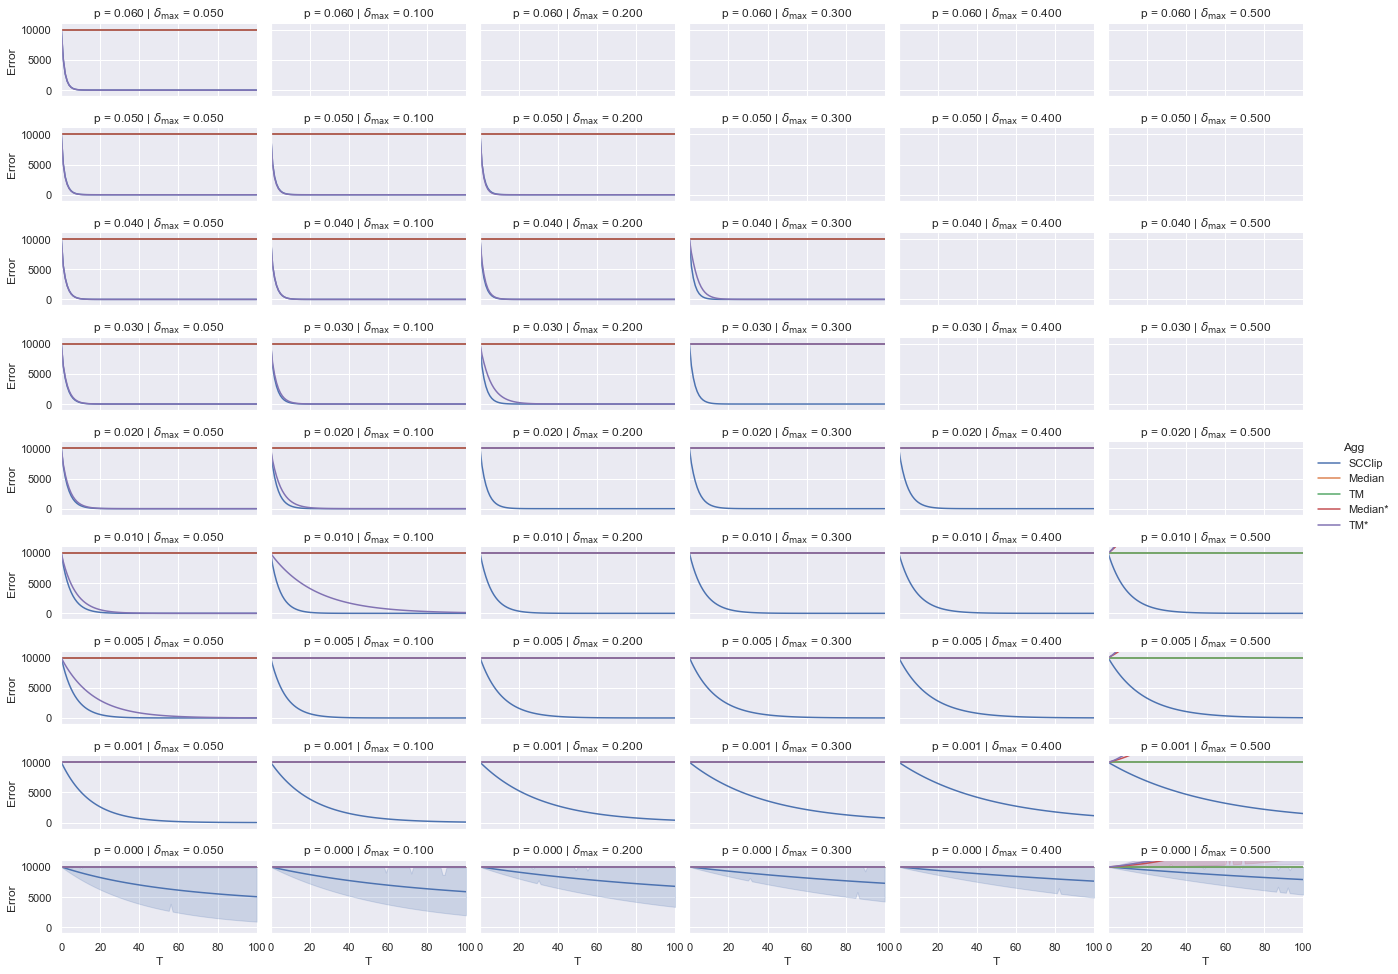

In [4]:
import pandas as pd
import seaborn as sns
stats = []
for res in results:
    delta_max, p = res['exp'].delta_max, res['exp'].p
    if res['attack'] == "constant":
        continue

    for t, e, cd in zip(range(res['exp'].T+1), res['exp'].errors, res['exp'].consensus_distances):
        if t > 100:
            break
        stats.append({r"$\delta_{\max}$ value": delta_max, "p_value": p, "Error": e, r"$\Xi$": cd, "T": t, "Agg": res['defense']})


plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 11
sns.set(rc={'figure.figsize': (6.75, 3)})

df = pd.DataFrame(stats)
df['p'] = df['p_value'].apply(lambda x: "{:.3f}".format(x))
df[r"$\delta_{\max}$"] = df[r"$\delta_{\max}$ value"].apply(lambda x: "{:.3f}".format(x))
g = sns.relplot(data=df, x="T", y="Error", col=r"$\delta_{\max}$", row="p", kind='line', hue="Agg", height=1.5, aspect=2)

g.set(xlim=(0, 100))
g.set(ylim=(-1000, 11001))
g.savefig("./consensus_dissensus_attack.pdf", bbox_inches="tight", dpi=720)

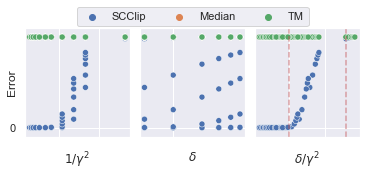

In [5]:
import pandas as pd
import seaborn as sns

stats = []
for res in results:
    delta_max, p = res['exp'].delta_max, res['exp'].p
    if res['defense'].endswith("*"):
        continue
    if res['attack'] == "constant":
        continue
    for t, e, cd in zip(range(res['exp'].T+1), res['exp'].errors, res['exp'].consensus_distances):
        if t > 100:
            break
        stats.append({r"$\delta_{\max}$ value": delta_max, "p_value": p, "Error": e, r"$\Xi$": cd, "T": t, "Agg": res['defense']})


df = pd.DataFrame(stats)
df = df[df['T'] == 100]
df[r'$\delta$'] = df[r"$\delta_{\max}$ value"]
df[r'$\delta/p$'] = df[r"$\delta_{\max}$ value"] / df['p_value'] ** 1
df[r'$\delta/\gamma^2$'] = df[r"$\delta_{\max}$ value"] / df['p_value'].apply(lambda p: (1- np.sqrt(1-p)) ** 2)
df[r'$1/\gamma^2$'] = 1 / df['p_value'].apply(lambda p: (1- np.sqrt(1-p)) ** 2)
df[r'$\delta/p^2$'] = df[r"$\delta_{\max}$ value"] / df['p_value'] ** 2

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 11
sns.set(rc={'figure.figsize': (6., 2)})
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True)

g = sns.scatterplot(data=df, x=r'$\delta/\gamma^2$', y="Error", hue="Agg", ax=axes[2], legend=False)
g.set_xscale('log')
g.get_xaxis().set_ticklabels([])
g.get_yaxis().set_ticks([0])

axes[2].axvline(x=100000, color='r', alpha=0.5, ls='--')
axes[2].axvline(x=2*10**11, color='r', alpha=0.5, ls='--')


g = sns.scatterplot(data=df, x=r'$\delta$', y="Error", hue="Agg", ax=axes[1], )
g.set_xscale('log')
g.get_xaxis().set_ticklabels([])

g = sns.scatterplot(data=df, x=r'$1/\gamma^2$', y="Error", hue="Agg", ax=axes[0], legend=False)
g.set_xscale('log')
g.get_xaxis().set_ticklabels([])

axes[0].set_ylabel('Error', labelpad=-8)
fig.subplots_adjust(wspace=0.093)

axes[0].set_ylim(-1000, 11000)
axes[1].legend(loc="lower left",  ncol=3, borderaxespad=0, bbox_to_anchor=(-0.6, 1.02, 1, 0.2))

fig.savefig("./consensus_dissensus_attack_scatter.pdf", bbox_inches="tight", dpi=720)